In [2]:
import numpy as np
from matplotlib import pyplot as plt
import skimage.transform as skimt
import time
import scipy.sparse as sp
import copy

import pyxu.operator as pyxop
import os
import src.tomo_fusion.tools.helpers as tomo_helps
import src.tomo_fusion.tools.plotting_fcts as tomo_plots
import src.tomo_fusion.bayesian_computations as bcomp
import src.tomo_fusion.functionals_definition as fct_def
import src.tomo_fusion.hyperparameter_tuning as hyper_tune

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
def postprocess_uq_data(uq_data_dir):
    # Load phantom data
    psis = np.load('../dataset_generation/sxr_samples/psis.npy')
    sxr_samples = np.load('../dataset_generation/sxr_samples/sxr_samples_with_background.npy')
    trim_val = np.load('../dataset_generation/sxr_samples/trimming_values.npy')

    # pixel value stats
    pixels_within_quantiles = np.zeros((900, 5))
    pixels_within_n_stds = np.zeros((900, 3))
    mse_map, mse_mean = np.zeros(900), np.zeros(900)
    mape_map, mape_mean = np.zeros(900), np.zeros(900)
    # peak location stats
    true_peak_loc = np.zeros((900, 2))
    peak_within_n_stds = np.zeros((900, 3))
    peak_distance_from_mean = np.zeros((900, 2))
    # prad stats
    true_prad_core = np.zeros(900)
    prad_within_n_stds = np.zeros((900, 3))
    prad_std_values = np.zeros(900)
    prad_rel_error_map, prad_rel_error_mean = np.zeros(900), np.zeros(900)
    prad_within_quantiles = np.zeros((900, 5))

    for idx in range(900):
        recon_shape = (120, 40)

        uq_data_idx = np.load(uq_data_dir + '/uq_data_' + str(idx) + '.npy', allow_pickle=True).item()
        quantile_marks = uq_data_idx['quantile_marks']

        ground_truth = sxr_samples[idx, :, :].squeeze()
        psi = psis[idx, :, :]

        mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val[idx, :])

        # compute pixels withing quantile bounds stats
        ground_truth_downsampled = skimt.resize(ground_truth, uq_data_idx["im_MAP"].shape, anti_aliasing=False,
                                                mode='edge')  # * mask_core
        core_pixels_number = ground_truth_downsampled[ground_truth_downsampled > 1e-3].size
        for j in range(5):
            # qunatile-related
            idxs = np.where((ground_truth_downsampled >= uq_data_idx["empirical_quantiles"][j, :, :]) & (
                        ground_truth_downsampled <= uq_data_idx["empirical_quantiles"][-(j + 1), :, :]))
            frac_pixels_within_quantiles_core = (idxs[0].size - (4800 - np.sum(mask_core))) / np.sum(mask_core)
            pixels_within_quantiles[idx, j] = frac_pixels_within_quantiles_core
        for j, nb_stds in enumerate(np.arange(1, 4)):
            # standard deviation-related
            pixels_within_n_stds_idxs = np.where((ground_truth_downsampled >= (uq_data_idx["mean"] - nb_stds * np.sqrt(uq_data_idx["var"]))) &
                                    (ground_truth_downsampled <= (uq_data_idx["mean"] + nb_stds * np.sqrt(uq_data_idx["var"]))))
            frac_pixels_within_n_stds_core = (pixels_within_n_stds_idxs[0].size - (4800 - core_pixels_number)) / core_pixels_number
            # frac_pixels_within_one_std_core = (idxs_one_std[0].size - (4800-np.sum(mask_core))) / np.sum(mask_core)
            pixels_within_n_stds[idx, j] = frac_pixels_within_n_stds_core
        mse_map[idx] = np.mean((ground_truth_downsampled - uq_data_idx["im_MAP"]) ** 2)
        mse_mean[idx] = np.mean((ground_truth_downsampled - uq_data_idx["mean"]) ** 2)
        mape_map[idx] = np.mean(np.abs((ground_truth_downsampled[mask_core] - uq_data_idx["im_MAP"][mask_core]) / ground_truth_downsampled[mask_core]))
        mape_mean[idx] = np.mean(np.abs((ground_truth_downsampled[mask_core] - uq_data_idx["mean"][mask_core])/ground_truth_downsampled[mask_core]))

        # compute peak location stats
        true_peak_loc[idx, :] = np.array(np.where(ground_truth == ground_truth.max())).reshape(2) / 2
        peak_distance_from_mean[idx, :] = (uq_data_idx["mean_peak_loc"] - true_peak_loc[idx, :]) * uq_data_idx["sampling"][0]
        for j, nb_stds in enumerate(np.arange(1, 4)):
            peak_within_n_stds[idx, j] = (
                    (np.abs(uq_data_idx["mean_peak_loc"][0] - true_peak_loc[idx, 0]) < nb_stds * np.sqrt(uq_data_idx["var_peak_loc"][0]))
                    and
                    (np.abs(uq_data_idx["mean_peak_loc"][1] - true_peak_loc[idx, 1]) < nb_stds * np.sqrt(uq_data_idx["var_peak_loc"][1])))

        # compute prad stats
        true_prad_core[idx] = tomo_helps.compute_radiated_power(ground_truth_downsampled, mask_core, uq_data_idx["sampling"])
        for j, nb_stds in enumerate(np.arange(1, 4)):
            prad_within_n_stds[idx, j] = np.abs(uq_data_idx["mean_prad_core"] - true_prad_core[idx]) < nb_stds * np.sqrt(uq_data_idx["var_prad_core"])
            #prad_within_n_stds[idx, j] = (uq_data_idx["mean_prad_core"] - true_prad_core) / np.sqrt(uq_data_idx["var_prad_core"])
        prad_std_values[idx] = np.sqrt(uq_data_idx["var_prad_core"])
        prad_rel_error_mean[idx] = (uq_data_idx["mean_prad_core"] - true_prad_core[idx]) / true_prad_core[idx]
        prad_rel_error_map[idx] = (uq_data_idx["prad_map_core"] - true_prad_core[idx]) / true_prad_core[idx]
        for j in range(5):
            prad_within_quantiles[idx, j] = (
                    (np.quantile(uq_data_idx["prads_core"], quantile_marks[-(j + 1)]) > true_prad_core[idx])
                    and
                    (np.quantile(uq_data_idx["prads_core"], quantile_marks[j]) < true_prad_core[idx])
            )
        postprocessed_uq_data = {"pixels_within_quantiles": pixels_within_quantiles, "pixels_within_n_stds": pixels_within_n_stds, "mse_map": mse_map,
                              "mse_mean": mse_mean, "mape_map": mape_map, "mape_mean": mape_mean,
                              "true_peak_loc": true_peak_loc, "peak_within_n_stds": peak_within_n_stds, "peak_distance_from_mean": peak_distance_from_mean,
                              "true_prad_core": true_prad_core, "prad_within_n_stds": prad_within_n_stds, "prad_std_values": prad_std_values,
                              "prad_rel_error_map": prad_rel_error_map, "prad_rel_error_mean": prad_rel_error_mean, "prad_within_quantiles": prad_within_quantiles,
                              "quantile_marks": quantile_marks}
        np.save(uq_data_dir + "/postprocessed_data.npy", postprocessed_uq_data)

In [5]:
results_dirs = ["uq_study_results/sigma005", "uq_study_results/sigma01", "uq_study_results/sigma005005", "uq_study_results/sigma005005new"]

In [6]:
for res_dir in results_dirs:
    postprocess_uq_data(res_dir)

/tmp/ipykernel_142091/3621769962.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_within_n_stds[idx, j] = np.abs(uq_data_idx["mean_prad_core"] - true_prad_core[idx]) < nb_stds * np.sqrt(uq_data_idx["var_prad_core"])
/tmp/ipykernel_142091/3621769962.py:70: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_std_values[idx] = np.sqrt(uq_data_idx["var_prad_core"])
/tmp/ipykernel_142091/3621769962.py:71: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  prad_rel_er

In [7]:
aggregate_data = []
for res_dir in results_dirs:
    aggregate_data.append(np.load(res_dir + "/postprocessed_data.npy", allow_pickle=True).item())

In [8]:
aggregate_data[3].keys()

dict_keys(['pixels_within_quantiles', 'pixels_within_n_stds', 'mse_map', 'mse_mean', 'mape_map', 'mape_mean', 'true_peak_loc', 'peak_within_n_stds', 'peak_distance_from_mean', 'true_prad_core', 'prad_within_n_stds', 'prad_std_values', 'prad_rel_error_map', 'prad_rel_error_mean', 'prad_within_quantiles', 'quantile_marks'])

# Analyze aggregate results

### Pixel value

First, we analyze whether appropriate bounds are computed for the individual pixel values.

In [9]:
noise_levels = [r"$\sigma=7\cdot 10^{-3}$", r"$\sigma=1.4\cdot 10^{-2}$", r"$\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$", r"$\sigma_{LoS}^{new}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$"]
quantile_credible_intervals = [round(100*(aggregate_data[0]["quantile_marks"][-(j+1)] - aggregate_data[0]["quantile_marks"][j])) for j in range(4)]
nb_stds = [r"", r"$2$", r"$3$"]

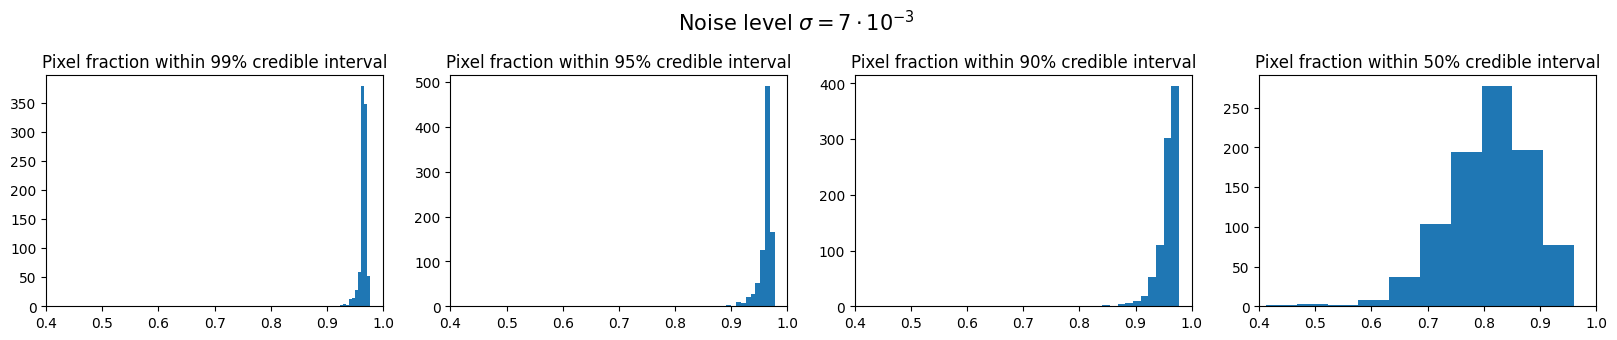

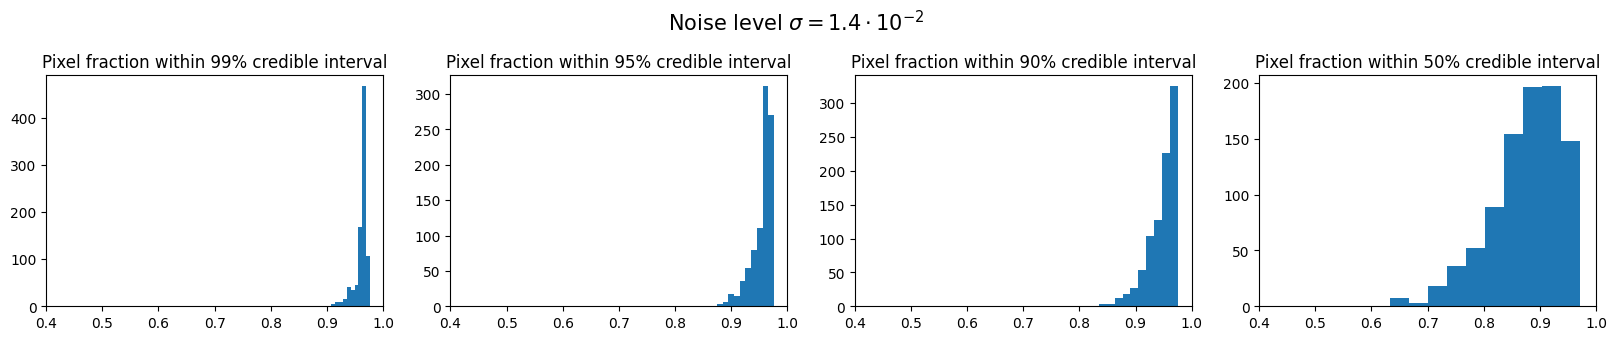

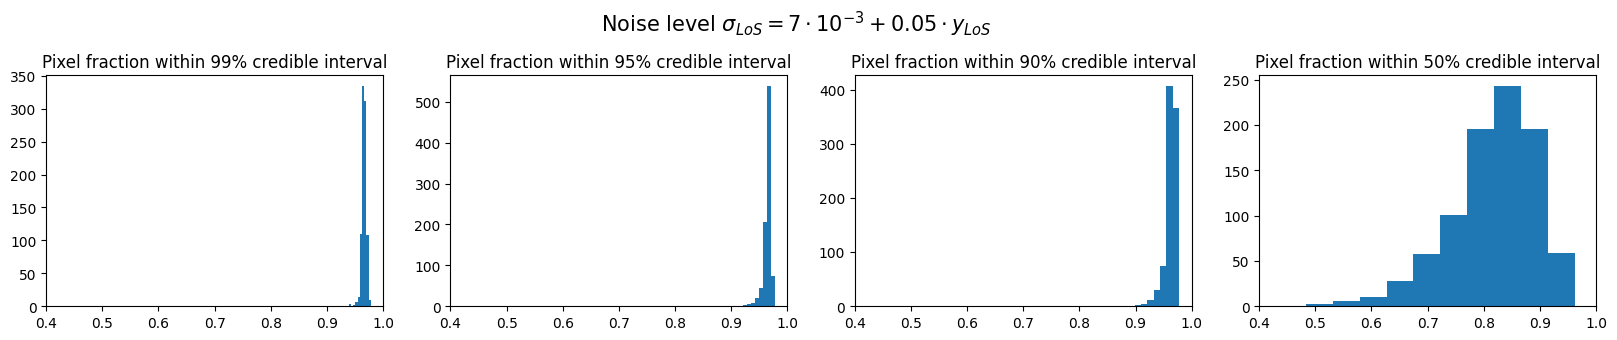

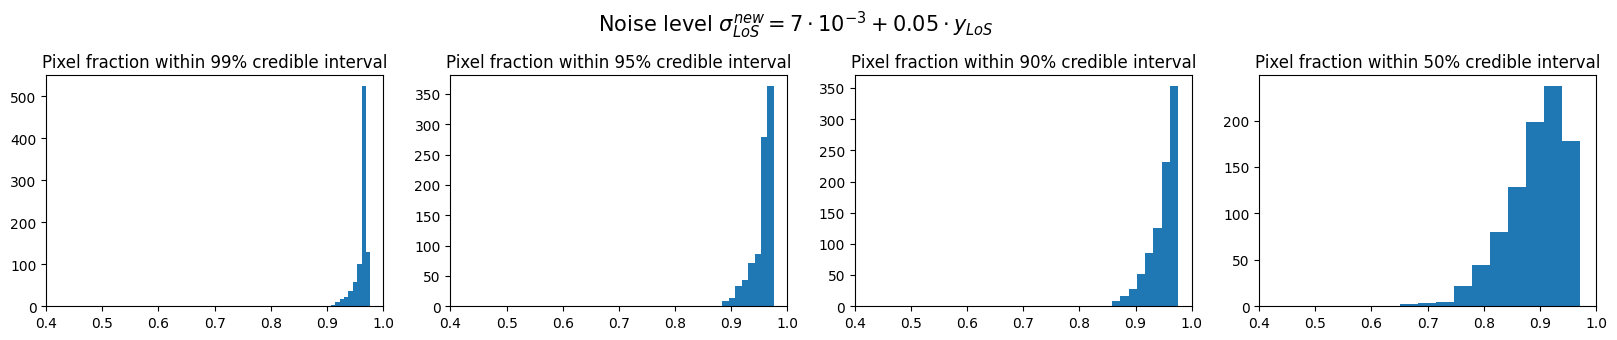

In [10]:
for i, noise_level in enumerate(noise_levels):
    fig, ax = plt.subplots(1,4, figsize=(20,3))
    for j, quantile_credible_interval in enumerate(quantile_credible_intervals):
        if i == 2 and j == 3:
            ax[j].hist(aggregate_data[i]["pixels_within_quantiles"][:,j+1], bins=10, density=False)
        else:
            ax[j].hist(aggregate_data[i]["pixels_within_quantiles"][:,j], bins=10, density=False)
        ax[j].set_xlim([0.4,1])
        ax[j].set_title("Pixel fraction within " + str(quantile_credible_interval) + "% credible interval")
    plt.suptitle("Noise level " + noise_level, y=1.1, fontsize=15)
    plt.show()


In [11]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    for j in range(4):
        if i == 2 and j == 3:
            print("Average (across phantoms) percentage of pixels falling within {:.0f} % credibility interval ".format(quantile_credible_intervals[j]),
                  100*np.mean(aggregate_data[i]["pixels_within_quantiles"][:,j+1]), "%")
        else:
            print("Average (across phantoms) percentage of pixels falling within {:.0f} % credibility interval ".format(quantile_credible_intervals[j]),
              100*np.mean(aggregate_data[i]["pixels_within_quantiles"][:,j]), "%")
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Average (across phantoms) percentage of pixels falling within 99 % credibility interval  96.48809966531203 %
Average (across phantoms) percentage of pixels falling within 95 % credibility interval  96.13503420437026 %
Average (across phantoms) percentage of pixels falling within 90 % credibility interval  95.65672455381777 %
Average (across phantoms) percentage of pixels falling within 50 % credibility interval  80.89016510835204 %


Noise level $\sigma=1.4\cdot 10^{-2}$
Average (across phantoms) percentage of pixels falling within 99 % credibility interval  96.15988949156088 %
Average (across phantoms) percentage of pixels falling within 95 % credibility interval  95.48051666989377 %
Average (across phantoms) percentage of pixels falling within 90 % credibility interval  94.65722751287278 %
Average (across phantoms) percentage of pixels falling within 50 % credibility interval  87.56802867588438 %


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cd

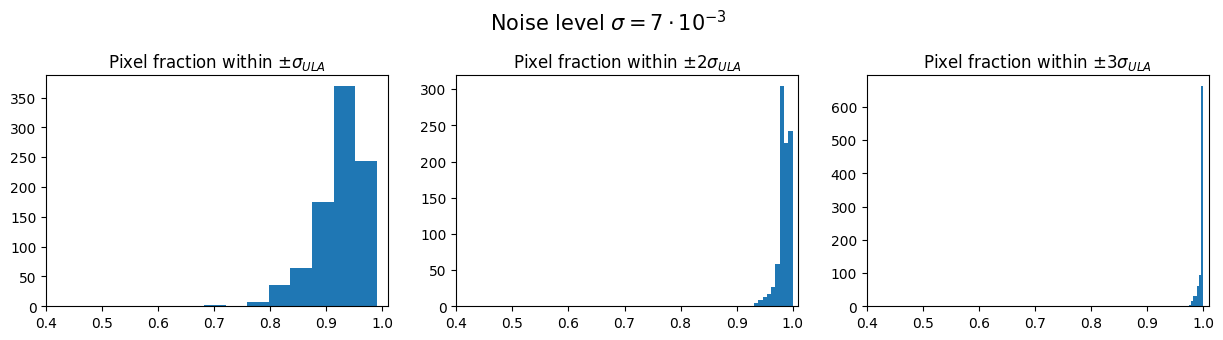

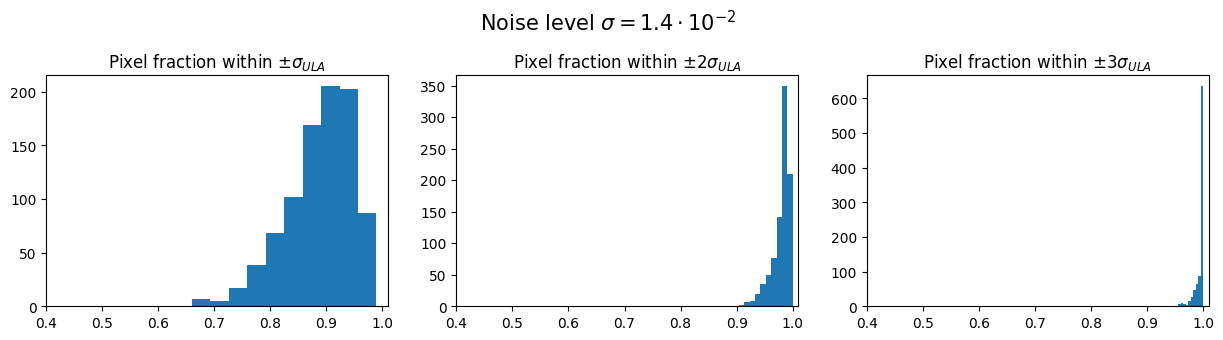

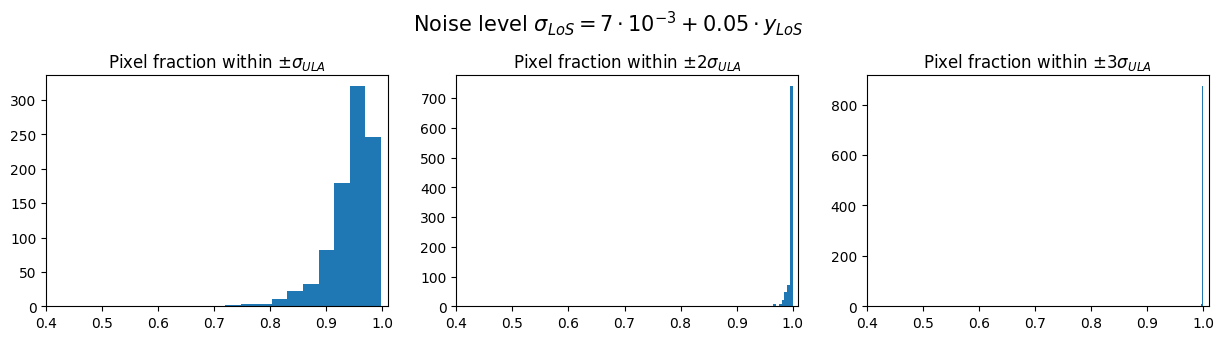

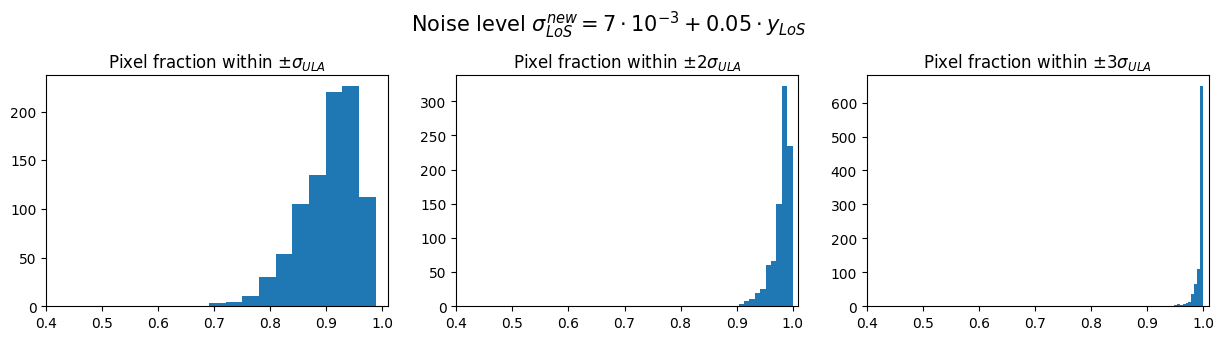

In [12]:
for i, noise_level in enumerate(noise_levels):
    fig, ax = plt.subplots(1,3, figsize=(15,3))
    for j, nb_stds in enumerate(np.arange(1,4)):
        ax[j].hist(aggregate_data[i]["pixels_within_n_stds"][:,j], bins=10, density=False)
        ax[j].set_xlim([0.4,1.01])
        if j == 0:
            ax[j].set_title(r"Pixel fraction within $\pm\sigma_{ULA}$")
        else:
            ax[j].set_title(r"Pixel fraction within $\pm$" + str(nb_stds) + r"$\sigma_{ULA}$")
    plt.suptitle("Noise level " + noise_level, y=1.1, fontsize=15)
    plt.show()

In [14]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print("Average (across phantoms) percentage of pixels falling within one standard deviation from the mean ",
          np.mean(aggregate_data[i]["pixels_within_n_stds"][:,0]), " +- ", np.std(aggregate_data[i]["pixels_within_n_stds"][:,0]))
    print("Average (across phantoms) percentage of pixels falling within two standard deviations from the mean ",
          np.mean(aggregate_data[i]["pixels_within_n_stds"][:,1]), " +- ", np.std(aggregate_data[i]["pixels_within_n_stds"][:,1]))
    print("Average (across phantoms) percentage of pixels falling within three standard deviations from the mean ",
          np.mean(aggregate_data[i]["pixels_within_n_stds"][:,2]), " +- ", np.std(aggregate_data[i]["pixels_within_n_stds"][:,2]))
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Average (across phantoms) percentage of pixels falling within one standard deviation from the mean  0.9230011285174102  +-  0.04406538355448803
Average (across phantoms) percentage of pixels falling within two standard deviations from the mean  0.9849623588943949  +-  0.011627069337321485
Average (across phantoms) percentage of pixels falling within three standard deviations from the mean  0.9970362525348292  +-  0.005394878651102485


Noise level $\sigma=1.4\cdot 10^{-2}$
Average (across phantoms) percentage of pixels falling within one standard deviation from the mean  0.8882198676277537  +-  0.05995695822554739
Average (across phantoms) percentage of pixels falling within two standard deviations from the mean  0.979550443885814  +-  0.016620116876665533
Average (across phantoms) percentage of pixels falling within three standard deviations from the mean  0.9954129498350349  +-  0.007978024046723568


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05

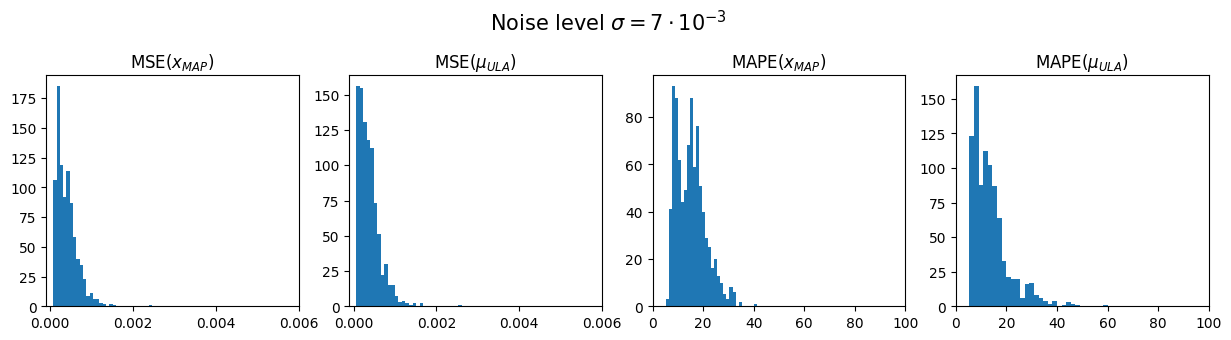

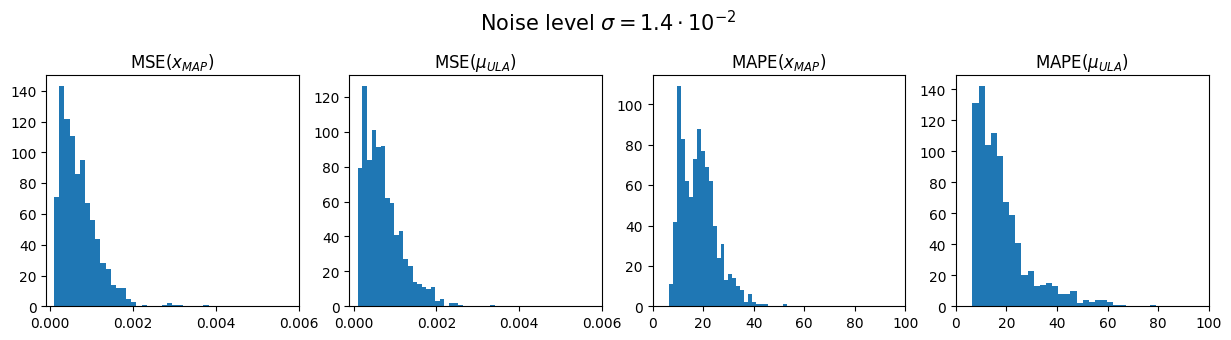

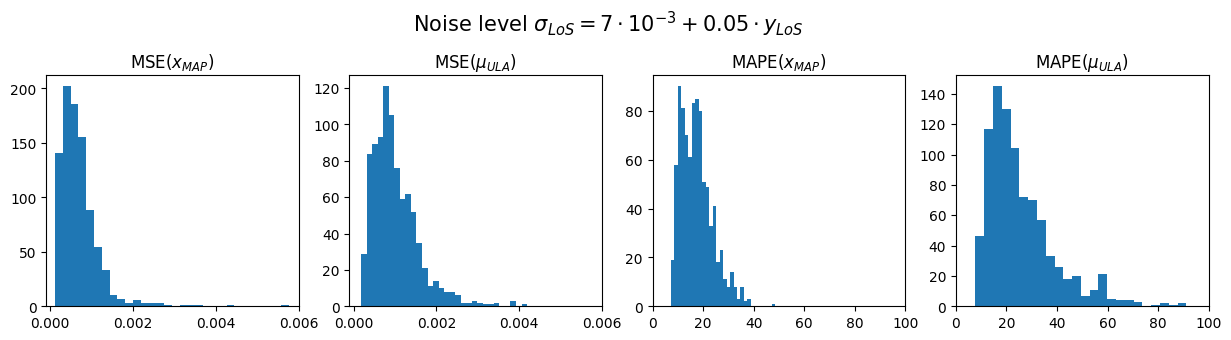

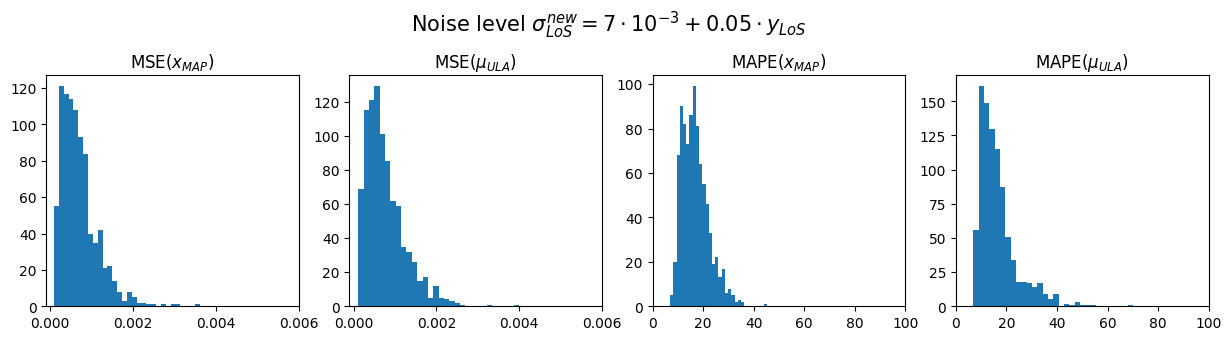

In [15]:
metrics = ["MSE", "MAPE"]

for i, noise_level in enumerate(noise_levels):
    fig, ax = plt.subplots(1,4, figsize=(15,3))
    ax[0].hist(aggregate_data[i]["mse_map"], bins=30)
    ax[0].set_xlim([-1e-4,6e-3])
    ax[0].set_title(r"MSE($x_{MAP}$)")
    ax[1].hist(aggregate_data[i]["mse_mean"], bins=30)
    ax[1].set_xlim([-1e-4,6e-3])
    ax[1].set_title(r"MSE($\mu_{ULA}$)")
    
    ax[2].hist(100*aggregate_data[i]["mape_map"], bins=30)
    ax[2].set_xlim([0,100])
    ax[2].set_title(r"MAPE($x_{MAP}$)")
    ax[3].hist(100*aggregate_data[i]["mape_mean"], bins=30)
    ax[3].set_xlim([0,100])
    ax[3].set_title(r"MAPE($\mu_{ULA}$)")
    
    plt.suptitle("Noise level " + noise_level, y=1.1, fontsize=15)
    plt.show()

In [16]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print("Average (across phantoms) mean squared error (MAP) ",
          np.mean(aggregate_data[i]["mse_map"]), " +- ", np.std(aggregate_data[i]["mse_map"]))
    print("Average (across phantoms) mean squared error (mean) ",
          np.mean(aggregate_data[i]["mse_mean"]), " +- ", np.std(aggregate_data[i]["mse_mean"]))
    print("Average (across phantoms) mean absolute percentage error (MAP) ",
          100*np.mean(aggregate_data[i]["mape_map"]), " +- ", 100*np.std(aggregate_data[i]["mape_map"]))
    print("Average (across phantoms) mean absolute percentage error (mean) ",
          100*np.mean(aggregate_data[i]["mape_mean"]), " +- ", 100*np.std(aggregate_data[i]["mape_mean"]))
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Average (across phantoms) mean squared error (MAP)  0.0003977206617747096  +-  0.0002513510286044221
Average (across phantoms) mean squared error (mean)  0.000380843667031099  +-  0.00025671904237561694
Average (across phantoms) mean absolute percentage error (MAP)  15.060665520574348  +-  5.8106808858288215
Average (across phantoms) mean absolute percentage error (mean)  13.74732516127416  +-  7.385529855178777


Noise level $\sigma=1.4\cdot 10^{-2}$
Average (across phantoms) mean squared error (MAP)  0.0006961884947332018  +-  0.00044797428477698017
Average (across phantoms) mean squared error (mean)  0.0007139737630198605  +-  0.0004604504766858231
Average (across phantoms) mean absolute percentage error (MAP)  18.369682883370807  +-  6.8987738440683
Average (across phantoms) mean absolute percentage error (mean)  18.334544510031257  +-  10.89302223636402


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Average (across phantoms) mea

### Peak location
We analyze accuracy of estimate of emission peak location.

In [17]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])

    print("Distance of true peak from estimated one {:.2f}".format(100*np.mean(np.linalg.norm(aggregate_data[i]["peak_distance_from_mean"], axis=1))), "cm +- {:.2f}".format(np.std(100*np.linalg.norm(aggregate_data[i]["peak_distance_from_mean"], axis=1))), "cm")
    
    print("Horizontal distance of true peak from estimated one {:.2f}".format(100*np.mean(aggregate_data[i]["peak_distance_from_mean"][:,1])), "cm +- {:.2f}".format(100*np.std(aggregate_data[i]["peak_distance_from_mean"][:,1])), "cm")
    
    print("Vertical distance of true peak from estimated one {:.2f}".format(100*np.mean(-aggregate_data[i]["peak_distance_from_mean"][:,0])), "cm +- {:.2f}".format(100*np.std(-aggregate_data[i]["peak_distance_from_mean"][:,0])), "cm")
    
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Distance of true peak from estimated one 4.32 cm +- 3.74 cm
Horizontal distance of true peak from estimated one -0.59 cm +- 3.40 cm
Vertical distance of true peak from estimated one -0.65 cm +- 4.51 cm


Noise level $\sigma=1.4\cdot 10^{-2}$
Distance of true peak from estimated one 5.55 cm +- 4.27 cm
Horizontal distance of true peak from estimated one -0.28 cm +- 3.82 cm
Vertical distance of true peak from estimated one -0.98 cm +- 5.79 cm


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Distance of true peak from estimated one 6.05 cm +- 4.28 cm
Horizontal distance of true peak from estimated one -0.79 cm +- 4.41 cm
Vertical distance of true peak from estimated one -0.51 cm +- 5.87 cm


Noise level $\sigma_{LoS}^{new}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Distance of true peak from estimated one 6.28 cm +- 4.62 cm
Horizontal distance of true peak from estimated one -0.12 cm +- 4.36 cm
Vertical distance of true peak from estimated one -1

In [19]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print("Percentage of phantoms such that true peak location is within one standard deviation from estimated location ", 100*np.mean(aggregate_data[i]["peak_within_n_stds"][:,0]), "%")
    print("Percentage of phantoms such that true peak location is within two standard deviations from estimated location ", 100*np.mean(aggregate_data[i]["peak_within_n_stds"][:,1]), "%")
    print("Percentage of phantoms such that true peak location is within three standard deviations from estimated location ", 100*np.mean(aggregate_data[i]["peak_within_n_stds"][:,2]), "%")
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Percentage of phantoms such that true peak location is within one standard deviation from estimated location  69.66666666666667 %
Percentage of phantoms such that true peak location is within two standard deviations from estimated location  98.0 %
Percentage of phantoms such that true peak location is within three standard deviations from estimated location  100.0 %


Noise level $\sigma=1.4\cdot 10^{-2}$
Percentage of phantoms such that true peak location is within one standard deviation from estimated location  62.55555555555555 %
Percentage of phantoms such that true peak location is within two standard deviations from estimated location  97.11111111111111 %
Percentage of phantoms such that true peak location is within three standard deviations from estimated location  99.66666666666667 %


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Percentage of phantoms such that true peak location is within one standard deviation from estimat

### Radiated power
We analyze accuracy of total radiated power estimation.

In [20]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print(r"Relative error on Prad MAP", 100*np.mean(aggregate_data[i]["prad_rel_error_map"]), "% +-", 100*np.std(aggregate_data[i]["prad_rel_error_map"]), "%")
    print(r"Relative error on Prad mean(ULA)", 100*np.mean(aggregate_data[i]["prad_rel_error_mean"]), "% +-", 100*np.std(aggregate_data[i]["prad_rel_error_mean"]), "%")
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Relative error on Prad MAP -0.28172879948247026 % +- 0.5759411425580864 %
Relative error on Prad mean(ULA) 0.4276600352743358 % +- 0.9730830783753949 %


Noise level $\sigma=1.4\cdot 10^{-2}$
Relative error on Prad MAP -0.5147530168888266 % +- 1.0633459660590858 %
Relative error on Prad mean(ULA) 0.9802497145486441 % +- 1.8791888483280457 %


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Relative error on Prad MAP -0.7063541236085144 % +- 0.8813522605834666 %
Relative error on Prad mean(ULA) 1.6384092043120961 % +- 2.0820366967238795 %


Noise level $\sigma_{LoS}^{new}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Relative error on Prad MAP -1.0270368523476958 % +- 0.9072553001548609 %
Relative error on Prad mean(ULA) 0.09957721323542762 % +- 1.3589233413722903 %




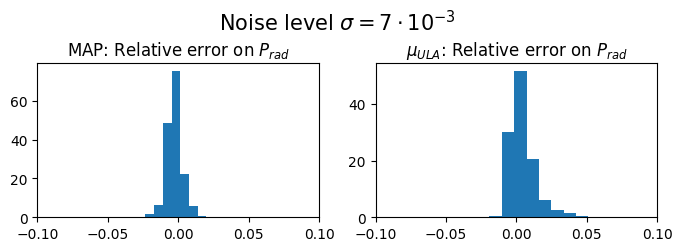

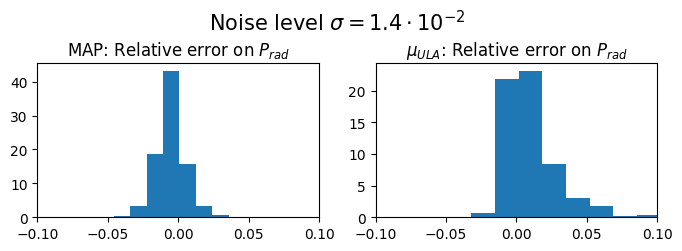

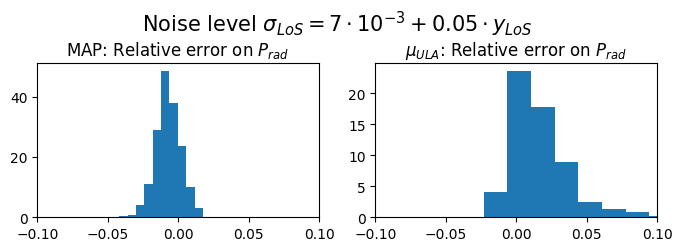

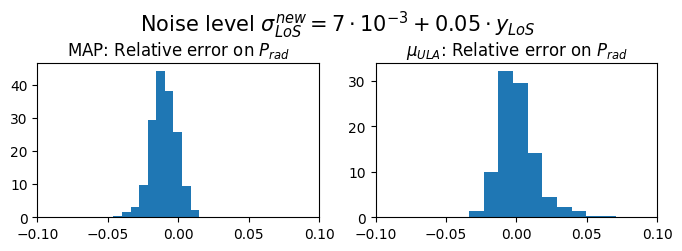

In [21]:
for i, noise_level in enumerate(noise_levels):
    fig, ax = plt.subplots(1,2, figsize=(8,2))
    ax[0].hist(aggregate_data[i]["prad_rel_error_map"], bins=10, density=True)
    ax[0].set_title(r"MAP: Relative error on $P_{rad}$")
    ax[0].set_xlim([-1e-1,1e-1])
    ax[1].hist(aggregate_data[i]["prad_rel_error_mean"], bins=10, density=True)
    ax[1].set_title(r"$\mu_{ULA}$: Relative error on $P_{rad}$")
    ax[1].set_xlim([-1e-1,1e-1])
    plt.suptitle("Noise level " + noise_level, y=1.15, fontsize=15)
    plt.show()

In [22]:
for i, noise_level in enumerate(noise_levels):
    print("Noise level " + noise_levels[i])
    print("Percentage of phantoms such that true radiated power is within one standard deviation from estimated value ", 100*np.mean(aggregate_data[i]["prad_within_n_stds"][:,0]), "%")
    print("Percentage of phantoms such that true radiated power is within two standard deviations from estimated value ", 100*np.mean(aggregate_data[i]["prad_within_n_stds"][:,1]), "%")
    print("Percentage of phantoms such that true radiated power is within three standard deviations from estimated value ", 100*np.mean(aggregate_data[i]["prad_within_n_stds"][:,2]), "%")
    print("\n")

Noise level $\sigma=7\cdot 10^{-3}$
Percentage of phantoms such that true radiated power is within one standard deviation from estimated value  56.111111111111114 %
Percentage of phantoms such that true radiated power is within two standard deviations from estimated value  85.55555555555556 %
Percentage of phantoms such that true radiated power is within three standard deviations from estimated value  96.0 %


Noise level $\sigma=1.4\cdot 10^{-2}$
Percentage of phantoms such that true radiated power is within one standard deviation from estimated value  50.888888888888886 %
Percentage of phantoms such that true radiated power is within two standard deviations from estimated value  80.77777777777779 %
Percentage of phantoms such that true radiated power is within three standard deviations from estimated value  93.66666666666667 %


Noise level $\sigma_{LoS}=7\cdot 10^{-3} + 0.05\cdot y_{LoS}$
Percentage of phantoms such that true radiated power is within one standard deviation from esti

In [152]:
ula_study = []

for i in range(100):
    if i<=39 or i>=50:
        #ula_data = np.load('hyperparameter_tuning/ula_hyperparameters_tuning/ula_iterations_number_tuning_sigma005/ula_data_'+str(900+i)+'.npy',allow_pickle=True)
        ula_data = np.load('hyperparameter_tuning/ula_hyperparameters_tuning/ula_iterations_number_tuning_sigma005005/ula_data_'+str(900+i)+'.npy',allow_pickle=True)
        ula_study.append(ula_data.item())

(1.0, 1995469.722999839)

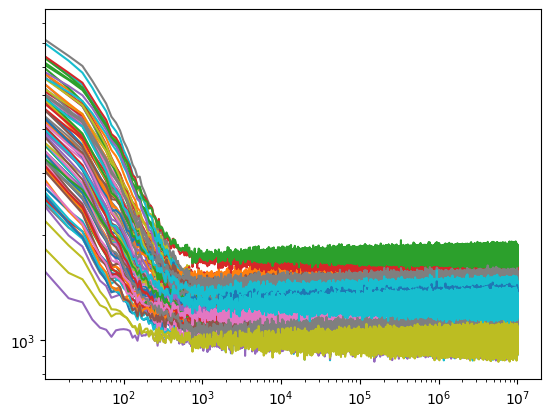

In [146]:
plt.figure()
for i in range(len(ula_study)):
    plt.plot(ula_study[i]["ula_obj_values"])
plt.xscale("log")
plt.yscale("log")
plt.xticks([1e1,1e2,1e3,1e4,1e5,1e6],
           [r"$10^2$",r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
plt.xlim([1,None])

In [153]:
mean_items, var_items, mean_prad_items, var_prad_items = [], [], [], []
for k in ula_study[0].keys():
    if 'mean' in k and 'prad' not in k:
        mean_items.append(ula_study[0][k])
    if 'var' in k and 'prad' not in k:
        var_items.append(ula_study[0][k])
    if 'mean_prad' in k:
        mean_prad_items.append(ula_study[0][k])
    if 'var_prad' in k:
        var_prad_items.append(ula_study[0][k])
mean_items, var_items = np.array(mean_items), np.array(var_items)
mean_prad_items, var_prad_items = np.array(mean_prad_items), np.array(var_prad_items)

In [154]:
mse_mean = np.mean((mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))**2, axis=(1,2))
mse_var = np.mean((var_items-np.stack([var_items[-1]]*var_items.shape[0]))**2, axis=(1,2))
mse_mean_prad = np.mean((mean_prad_items-np.stack([mean_prad_items[-1]]*mean_prad_items.shape[0]))**2, axis=1)
mse_var_prad = np.mean((var_prad_items-np.stack([var_prad_items[-1]]*var_prad_items.shape[0]))**2, axis=1)

In [155]:
mapes_mean, mapes_var = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)) 
mses_mean, mses_var = np.zeros((len(ula_study), 25)), np.zeros((len(ula_study), 25)) 

for i in range(len(ula_study)):
    
    mean_items, var_items, mean_prad_items, var_prad_items = [], [], [], []
    for k in ula_study[i].keys():
        if 'mean' in k and 'prad' not in k:
            mean_items.append(ula_study[i][k])
        if 'var' in k and 'prad' not in k:
            var_items.append(ula_study[i][k])
        if 'mean_prad' in k:
            mean_prad_items.append(ula_study[i][k])
        if 'var_prad' in k:
            var_prad_items.append(ula_study[i][k])
    mean_items, var_items = np.array(mean_items), np.array(var_items)
    mean_prad_items, var_prad_items = np.array(mean_prad_items), np.array(var_prad_items)
    
    
    mses_mean[i,:] = np.mean((mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))**2, axis=(1,2))
    mape_mean = np.abs(mean_items-np.stack([mean_items[-1]]*mean_items.shape[0]))
    mean_positive_locs = np.where(mean_items[-1]>1e-3)
    mape_mean[:,mean_positive_locs[0], mean_positive_locs[1]] /= mean_items[-1][mean_positive_locs[0], mean_positive_locs[1]]
    mapes_mean[i,:] = np.mean(mape_mean[:,mean_positive_locs[0],mean_positive_locs[1]],axis=1)
    
    mses_var[i,:] = np.mean((var_items-np.stack([var_items[-1]]*var_items.shape[0]))**2, axis=(1,2))
    mape_var = np.abs(var_items-np.stack([var_items[-1]]*var_items.shape[0]))
    var_positive_locs = np.where(var_items[-1]>1e-3)
    mape_var[:,var_positive_locs[0], var_positive_locs[1]] /= var_items[-1][var_positive_locs[0], var_positive_locs[1]]
    mapes_var[i,:] = np.mean(mape_var[:,var_positive_locs[0],var_positive_locs[1]],axis=1)


Text(0.5, 1.0, 'MSE $\\sigma_{_{ULA}}$')

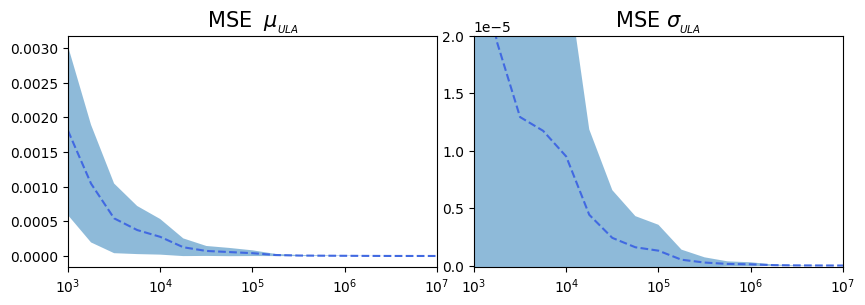

In [156]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace=0.1)
mse_mean_avg = np.mean(mses_mean[:,8:],axis=0)
mse_mean_std = np.std(mses_mean[:,8:],axis=0)
ax[0].plot(mse_mean_avg, '--', color="royalblue")
ax[0].fill_between(np.arange(0,17), mse_mean_avg-mse_mean_std,  mse_mean_avg+mse_mean_std, alpha=0.5)
ax[0].set_xticks([0,4,8,12,16])
ax[0].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
#ax[0].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
#ax[0].set_ylim([-0.001,0.41])
ax[0].set_xlim([0,16])
ax[0].set_title(r"MSE $\;\mu_{_{ULA}}$", fontsize=15)

mse_var_avg = np.mean(mses_var[:,8:],axis=0)
mse_var_std = np.std(mses_var[:,8:],axis=0)
ax[1].plot(mse_var_avg, '--', color="royalblue")
ax[1].fill_between(np.arange(0,17), mse_var_avg-mse_var_std,  mse_var_avg+mse_var_std, alpha=0.5)
ax[1].set_xticks([0,4,8,12,16])
ax[1].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
#ax[1].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
ax[1].set_ylim([-1e-7,2e-5])
ax[1].set_xlim([0,16])
ax[1].set_title(r"MSE $\sigma_{_{ULA}}$", fontsize=15)

Text(0.5, 1.0, 'MAPE $\\sigma_{_{ULA}}$')

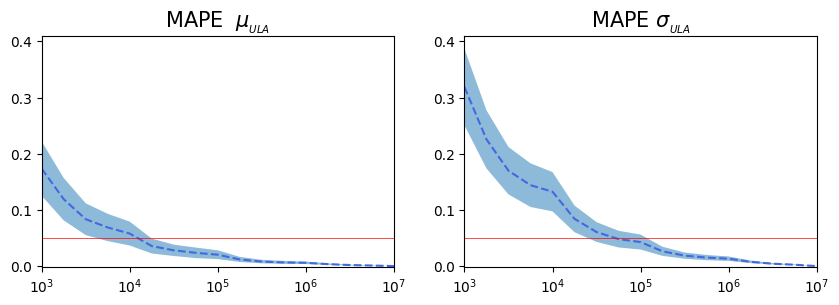

In [157]:
fig, ax = plt.subplots(1,2,figsize=(10,3))
plt.subplots_adjust(wspace=0.2)

mape_mean_avg = np.mean(mapes_mean[:,8:],axis=0)
mape_mean_std = np.std(mapes_mean[:,8:],axis=0)
ax[0].plot(mape_mean_avg, '--', color="royalblue")
ax[0].fill_between(np.arange(0,17), mape_mean_avg-mape_mean_std,  mape_mean_avg+mape_mean_std, alpha=0.5)
ax[0].set_xticks([0,4,8,12,16])
ax[0].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
ax[0].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
ax[0].set_ylim([-0.001,0.41])
ax[0].set_xlim([0,16])
ax[0].set_title(r"MAPE $\;\mu_{_{ULA}}$", fontsize=15)

mape_var_avg = np.mean(mapes_var[:,8:],axis=0)
mape_var_std = np.std(mapes_var[:,8:],axis=0)
ax[1].plot(mape_var_avg, '--', color="royalblue")
ax[1].fill_between(np.arange(0,17), mape_var_avg-mape_var_std,  mape_var_avg+mape_var_std, alpha=0.5)
ax[1].set_xticks([0,4,8,12,16])
ax[1].set_xticklabels([r"$10^3$",r"$10^4$",r"$10^5$",r"$10^6$",r"$10^7$"])
ax[1].plot(np.ones(int(17))*0.05,'r',linewidth=0.5)
ax[1].set_ylim([-0.001,0.41])
ax[1].set_xlim([0,16])
ax[1].set_title(r"MAPE $\sigma_{_{ULA}}$", fontsize=15)
#ax[1].set_xlabel(r"$N_{ULA}$")

### Why mean stats are so bad for signal dependent noise?

In [310]:
# Load phantom data
psis = np.load('../dataset_generation/sxr_samples/psis.npy')
sxr_samples = np.load('../dataset_generation/sxr_samples/sxr_samples_with_background.npy')
alphas = np.load('../dataset_generation/sxr_samples/alpha_random_values.npy')
trim_vals = np.load('../dataset_generation/sxr_samples/trimming_values.npy')
random_peak_vals = np.load('../dataset_generation/sxr_samples/peak_values_gaussian_background.npy')

idx = 99
#294,300,360,400,407
recon_shape = (120, 40)

anis_data_idx = np.load('uq_study_results/sigma005005/anis_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx_005 = np.load('uq_study_results/sigma005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx_01 = np.load('uq_study_results/sigma01/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx_005005 = np.load('uq_study_results/sigma005005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()
uq_data_idx_005005new = np.load('uq_study_results/sigma005005new/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()

ground_truth = sxr_samples[idx, :, :].squeeze()
psi = psis[idx, :, :]
trim_val = trim_vals[idx, :]


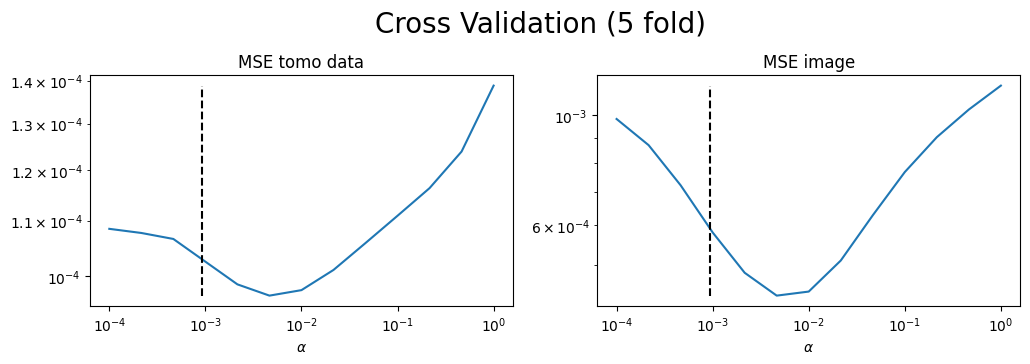

ValueError: Unknown key time

In [311]:
tomo_plots.plot_hyperparam_tuning_data(anis_data_idx, "anis_param", true_param_val=alphas[idx])

In [289]:
reg_param

0.03162277660168379

In [290]:
mse1 = np.zeros(100)
mse2=np.zeros(100)
for i in range(100):
    ground_truth = sxr_samples[i, :, :].squeeze()
    gts = skimt.resize(ground_truth, (120,40), anti_aliasing=False, mode='edge')
    psi = psis[i, :, :]
    trim_val = trim_vals[i, :]
    uq_data_idx_005005 = np.load('uq_study_results/sigma005005/uq_data_'+str(idx)+'.npy', allow_pickle=True).item()
    f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=uq_data_idx_005005["sigma_err"],
                                                reg_fct_type="anisotropic",
                                                    #alpha=uq_data_idx_005005["alpha"],
                                                    alpha=alphas[i],
                                                    seed=idx)

    mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val)
    map1=bcomp.compute_MAP(f, g, 0.1, with_pos_constraint=True, clipping_mask=mask_core)
    mse1[i]=np.mean((map1-gts)**2)
    map2=bcomp.compute_MAP(f, g, reg_param, with_pos_constraint=True, clipping_mask=mask_core)
    mse2[i]=np.mean((map2-gts)**2)

INFO -- [2025-01-08 12:46:21.571300] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-01-08 12:46:22.398850] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2025-01-08 12:46:22.690275] Iteration 1_454
	iteration: 1454
	N_iter: 1455
	RelError[x]: 0
INFO -- [2025-01-08 12:46:22.691153] Stopping Criterion satisfied -> END
INFO -- [2025-01-08 12:46:22.701803] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-01-08 12:46:23.330206] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2025-01-08 12:46:23.370251] Iteration 1_064
	iteration: 1064
	N_iter: 1065
	RelError[x]: 0
INFO -- [2025-01-08 12:46:23.371240] Stopping Criterion satisfied -> END
INFO -- [2025-01-08 12:46:23.476761] Iteration 0
	iteration: 0
	N_iter: 1
	RelError[x]: 0
INFO -- [2025-01-08 12:46:24.098741] Iteration 1_000
	iteration: 1000
	N_iter: 1001
	RelError[x]: 0
INFO -- [2025-01-08 12:46:24.209721] Iteration 1_177
	iteration: 1177
	N_iter: 1178


In [293]:
np.mean(mse1)

np.float64(0.0009336363481266295)

In [294]:
np.mean(mse2)

np.float64(0.0006311513143716555)

In [35]:
reg_param = np.load('hyperparameter_tuning/prior_hyperparameters_tuning/tuning_data/reg_param_tuning_sigma005005/reg_param_median.npy', allow_pickle=True).item()

In [36]:
reg_param

0.03162277660168379

In [37]:
np.load('hyperparameter_tuning/prior_hyperparameters_tuning/tuning_data/reg_param_tuning_sigma005005/reg_param_mean.npy', allow_pickle=True).item()

0.06364134818396538

In [312]:
f,g = fct_def.define_loglikelihood_and_logprior(ground_truth, psi, sigma_err=uq_data_idx_005005new["sigma_err"],
                                                reg_fct_type="anisotropic", alpha=uq_data_idx_005005new["alpha"], seed=idx)

mask_core = tomo_helps.define_core_mask(psi=psi, dim_shape=recon_shape, trim_values_x=trim_val)

In [185]:
#ula_stats_longer_burnin = bcomp.run_ula(f, g, 0.1, psi, trim_val, with_pos_constraint=True, clip_iterations="core", burn_in=int(1e3), samples=int(1e5), compute_stats_wrt_MAP=True, show_progress=True)

In [320]:
ula_stats_longer_burnin = uq_data_idx_005005new
ula_stats_longer_burnin = uq_data_idx_005005

In [321]:
gtds = skimt.resize(ground_truth, ula_stats_longer_burnin["im_MAP"].shape, anti_aliasing=False, mode='edge')
psids = skimt.resize(psi, ula_stats_longer_burnin["im_MAP"].shape, anti_aliasing=False, mode='edge')

In [322]:
print("MSE (MAP)", np.mean((ula_stats_longer_burnin["im_MAP"]-gtds)**2))
print("MSE (mean)", np.mean((ula_stats_longer_burnin["mean"]-gtds)**2))

MSE (MAP) 0.00040464784415214614
MSE (mean) 0.000894905979078864


In [318]:
print("MSE (MAP)", np.mean((ula_stats_longer_burnin["im_MAP"]-gtds)**2))
print("MSE (mean)", np.mean((ula_stats_longer_burnin["mean"]-gtds)**2))

MSE (MAP) 0.0003502189108684938
MSE (mean) 0.0005136974540199013


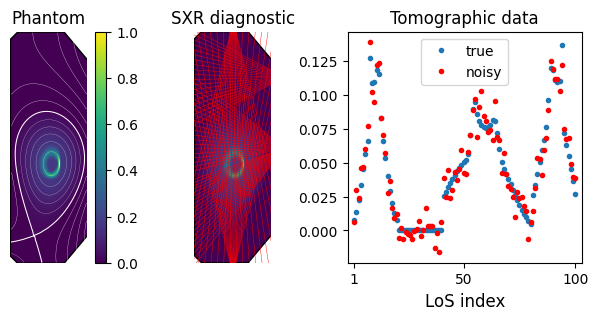

In [313]:
tomo_plots.plot_phantom_and_sxr_diag(ground_truth=ground_truth, psi=psi, tomo_data=f.tomo_data, noisy_tomo_data=f.noisy_tomo_data, tcv_plot_clip=True)

Text(0.5, 1.0, 'Mean')

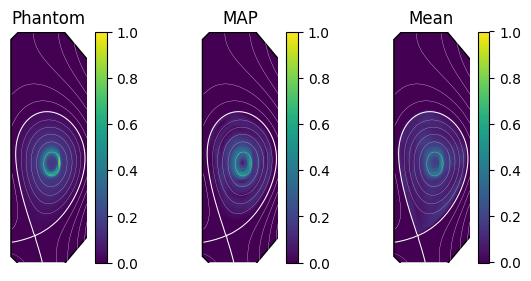

In [323]:
fig,ax=plt.subplots(1,3, figsize=(7,3))

tomo_plots.plot_profile(gtds, tcv_plot_clip=True, contour_image=psids, levels=12,
                   ax=ax[0], colorbar=True, contour_color="w", vmax=1)
ax[0].set_title("Phantom")
tomo_plots.plot_profile(ula_stats_longer_burnin["im_MAP"], tcv_plot_clip=True, contour_image=psids, levels=12,
                   ax=ax[1], colorbar=True, contour_color="w", vmax=1)
ax[1].set_title("MAP")
tomo_plots.plot_profile(ula_stats_longer_burnin["mean"], tcv_plot_clip=True, contour_image=psids, levels=12,
                   ax=ax[2], colorbar=True, contour_color="w", vmax=1)
ax[2].set_title("Mean")

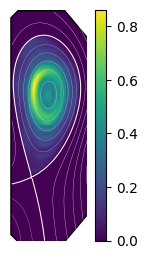

In [287]:
tomo_plots.plot_profile(ula_stats_longer_burnin["mean"], tcv_plot_clip=True, contour_image=psids, levels=12,
                   colorbar=True, contour_color="w", vmax=np.max(ula_stats_longer_burnin["mean"]))

Text(0.5, 1.0, 'MSE (mean)')

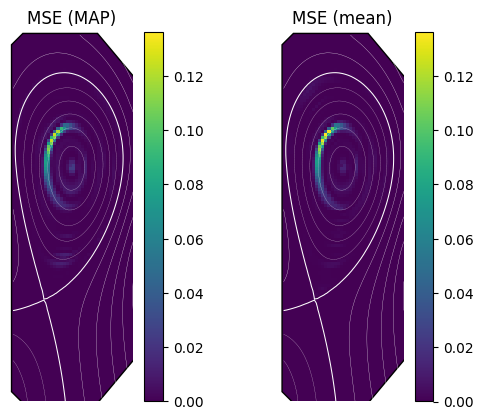

In [94]:
fig,ax=plt.subplots(1,2)
vmax=np.max([np.max((ula_stats_longer_burnin["im_MAP"]-gtds)**2), np.max((ula_stats_longer_burnin["mean"]-gtds)**2)])
tomo_plots.plot_profile((ula_stats_longer_burnin["im_MAP"]-gtds)**2, tcv_plot_clip=True, contour_image=psids, levels=12,
                   ax=ax[0],colorbar=True, contour_color="w", vmax=vmax)
ax[0].set_title("MSE (MAP)")
tomo_plots.plot_profile((ula_stats_longer_burnin["mean"]-gtds)**2, tcv_plot_clip=True, contour_image=psids, levels=12,
                   ax=ax[1],colorbar=True, contour_color="w", vmax=vmax)
ax[1].set_title("MSE (mean)")

In [334]:
central_core = np.where( psids<-5)
print("MSE (MAP)", np.mean((ula_stats_longer_burnin["im_MAP"][central_core]-gtds[central_core])**2))
print("MSE (mean)", np.mean((ula_stats_longer_burnin["mean"][central_core]-gtds[central_core])**2))

MSE (MAP) 0.0018166930943468399
MSE (mean) 0.0025579588200902426


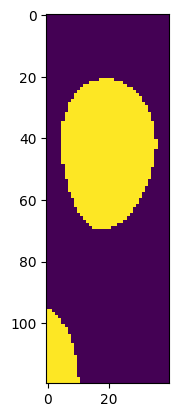

In [266]:
ff=np.zeros((120,40))
ff[central_core] = 1
plt.imshow(ff)

Study correlation between difference in MSE and random peak value

In [292]:
from scipy.stats import pearsonr

pearsonr(random_peak_vals[:900], aggregate_data[2]["mse_map"]/aggregate_data[2]["mse_mean"])

PearsonRResult(statistic=np.float64(0.3028941475259558), pvalue=np.float64(1.4947463304900155e-20))

(array([[0., 2., 2., ..., 0., 0., 0.],
        [0., 1., 1., ..., 0., 0., 0.],
        [0., 1., 3., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0.20043677, 0.22041141, 0.24038605, 0.26036069, 0.28033533,
        0.30030997, 0.32028462, 0.34025926, 0.3602339 , 0.38020854,
        0.40018318, 0.42015782, 0.44013246, 0.4601071 , 0.48008174,
        0.50005638, 0.52003102, 0.54000566, 0.5599803 , 0.57995494,
        0.59992958, 0.61990422, 0.63987886, 0.65985351, 0.67982815,
        0.69980279, 0.71977743, 0.73975207, 0.75972671, 0.77970135,
        0.79967599, 0.81965063, 0.83962527, 0.85959991, 0.87957455,
        0.89954919, 0.91952383, 0.93949847, 0.95947311, 0.97944775,
        0.9994224 ]),
 array([0.17808728, 0.23608406, 0.29408084, 0.35207762, 0.4100744 ,
        0.46807118, 0.52606796, 0.58406474, 0.64206152, 0.7000583 ,
        0.75805508, 0.81605186, 0.87404864, 0.932

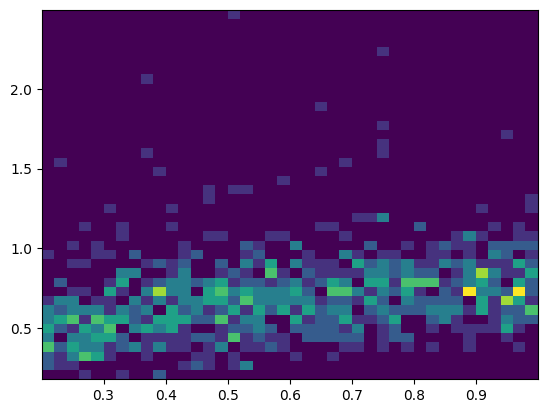

In [301]:
plt.hist2d(random_peak_vals[:900], aggregate_data[2]["mse_map"]/aggregate_data[2]["mse_mean"], bins=40)

In [291]:
np.mean( aggregate_data[2]["mse_map"]/aggregate_data[2]["mse_mean"])

np.float64(0.6937684120951225)

(array([ 83., 314., 344., 122.,  20.,   8.,   5.,   1.,   2.,   1.]),
 array([0.17808728, 0.4100744 , 0.64206152, 0.87404864, 1.10603576,
        1.33802288, 1.57001   , 1.80199712, 2.03398424, 2.26597136,
        2.49795848]),
 <BarContainer object of 10 artists>)

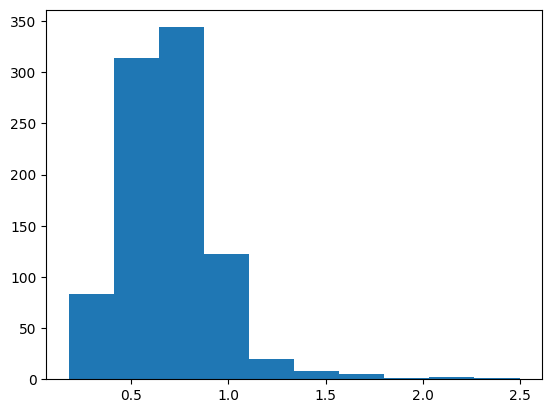

In [293]:
plt.hist(( aggregate_data[2]["mse_map"]/aggregate_data[2]["mse_mean"]))

In [318]:
idxs_large_peak=np.where(random_peak_vals[:900]>0.9)

In [319]:
idxs_large_peak[0].size

123

(array([ 8., 27., 34., 29., 16.,  5.,  3.,  0.,  0.,  1.]),
 array([0.39216519, 0.52407709, 0.65598899, 0.78790089, 0.91981279,
        1.05172469, 1.18363659, 1.31554849, 1.44746039, 1.57937229,
        1.71128419]),
 <BarContainer object of 10 artists>)

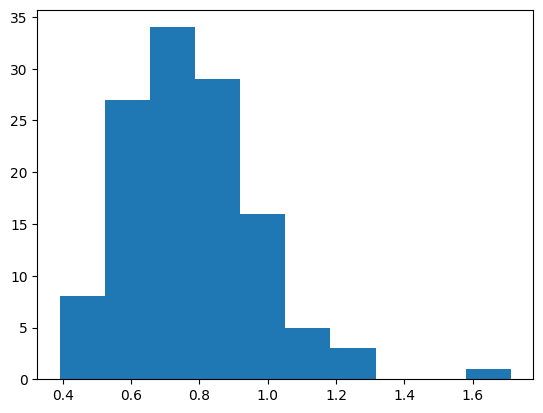

In [320]:
plt.hist(( aggregate_data[2]["mse_map"][idxs_large_peak]/aggregate_data[2]["mse_mean"][idxs_large_peak]))

In [321]:
np.mean(( aggregate_data[2]["mse_map"][idxs_large_peak]/aggregate_data[2]["mse_mean"][idxs_large_peak]))

np.float64(0.7759685011654249)